# Szagtalan Kálmán-szűrő (UKF)

A kibővített Kálmán-szűrő problémái:

* linearizáció: csak a Taylor-sor elsőrendű tagját veszi figyelembe
* a Jacobi-mátrix előállítása nehézkes
* nehezen beállítható a szűrő paraméterezése, némely esetben a szűrő divergáló rendszer állapotot becsül

A tapasztalatok szerint a szagtalan Kálmán-szűrő (**Unscented Kalman Filter**, **UKF**) legalább olyan jó mint az EKF, sokszor jobb.

<img src="img/Uhlmann.jpg" style="float:right;" width="100" />

Honnan a bizarr név? Idézzük a név megalkotóját, Jeffrey Uhlmann-t:

"Miért „szagtalan”? „Kezdetben »új szűrő« volt a neve, de mivel jellegzetesebb névre volt szükség, ezért egyesek »Uhlmann szűrőnek« kezdték hívni, amit nyilván nem használhattam. Egyik este mindenki más a laborból a Royal Opera House-ba ment. Miközben dolgoztam, észrevettem valaki dezodorát az asztalon. A »szagtalan« (»unscented«) felirat szemet szúrt, ami tökéletes név volt. A laborban először abszurdnak találták – ami rendben van, mert az abszurditás a vezérelvem.” [Jeffrey Uhlmann](http://ethw.org/First-Hand:The_Unscented_Transform )

## Az UKF alapötlete

A Kálmán-szűrés lineáris transzformáción keresztül a Gauss-eloszlású rendszer állapotának terjedését és méréseken alapuló frissítését írja le. Mivel a Gauss-eloszlást, általánosabban egy valószínűségeloszlást könnyebben lehet közelíteni, mint a nemlineáris transzformációt, ezért megtartjuk a nemlineáris transzformációt, és a Gauss-eloszlás paramétereit (várható érték és kovariancia) közelítjük diszkrét pontok (ún. **szigma pontok**) halmaza segítségével. Ez a **szagtalan transzformáció** (és a szagtalan Kálmán-szűrés) lényege:

1. felvesszük a szigma pontokat úgy, hogy pontosan jellemezzék a rendszer állapot átlagát és kovarianciáját
2. a szigma pontokat átvisszük a nemlineáris $f$, $h$ transzformációval az állapot- ill. mérési térbe
3. az átvitt pontokból számítjuk közelítőleg a rendszer állapot átlagot és kovarianciát

<img src="img/UKF_idea.png" width="450">

Az eljárás tehát rokona a *Monte-Carlo* módszereknek azzal a különbséggel, hogy a diszkrét pontokat nem véletlenszerűen, hanem determinisztikusan vesszük fel.

### Szigma pontok

<img src="img/sigma.png" width="450">
<div style="text-align:center;font-size:8px;">forrás: Roger R Labbe: [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)</div>

$n$ dimenziós állapottérben $2n + 1$ db. $\mathbf{X}_i$ **<span style="color:blue;">szigma pontot</span>** választunk ki

a transzformált szigma pontokat $W_i$ súlyokkal súlyozzuk


### Van der Merwe-féle skálázott szigma pontok 

A szigma pontok halmazát a következő összefüggések szolgáltatják:

$$ \mathbf{X_{0}}=\mathbf{\mu }$$

$$ \mathbf{X_{i}}=\mathbf{\mu }+\left [\sqrt{\left (n+\lambda \right )\mathbf{P}}\right ]_{i}\qquad i=1,...,n$$

$$ \mathbf{X_{i}}=\mathbf{\mu }- \left [\sqrt{\left (n+\lambda \right )\mathbf{P}}\right ]_{i-n}\qquad i=n+1,...,2n$$

ahol $\left [\mathbf{A}\right ]_{i}$ a szimmetrikus $\mathbf{A}$ mátrix $i$-edik oszlopát (vagy sorát) jelöli és 

$$\lambda =\alpha ^{2}\left (n+k\right )- n,\qquad k=3- n.$$

A $\lambda$ egy skálatényező, az $\alpha$ paraméter határozza meg a szigma pontok távolságát a $\mathbf{\mu }$ ponttól, $k$ pedig egy másik skálatényező.

<img src="img/merwe.png" width="350">
<div style="text-align:center;font-size:8px;">forrás: Roger R Labbe: [Kalman and Bayesian Filters in Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python)</div>

Láthatjuk, hogy a szigma pontok számításához a $\mathbf{P}$ rendszer állapot (szimmetrikus és pozitív definit) kovariancia mátrixának *négyzetgyöke* kiszámítására van szükség. Mivel a mátrix szimmetrikus, ezért erre a célra előnyösen használható a mátrix Cholesky felbontása, $\mathbf{P} = \mathbf{L}\mathbf{L}^T$. Az $\mathbf{L}$ alsó háromszögmátrix a $\mathbf{P}$ mátrix egyfajta "négyzetgyökének" tekinthető.




### Van der Merwe-féle súlyok

$$W_{0}^{m}=\frac{\lambda }{n+\lambda }$$

$$W_{0}^{c}=\frac{\lambda }{n+\lambda }+1- \alpha ^{2}+\beta$$

$$W_{i}^{m} = W_{i}^{c}=\frac{1 }{2(n+\lambda)}, \qquad i=1,...,2n$$

Gauss-eloszlás esetén az alábbi paramétereket célszerű használni:

$\beta=2$, $k=3-n$, $0\le \alpha \le 1$.

### Szagtalan transzformáció

A szagtalan transzformáció során ezeket a szigma vektorokat transzformáljuk egy nemlineáris 

$$\mathbf{Y}_i = g(\mathbf{X}_i)\qquad i=0,...,2n$$

függvény segítségével, és az eredményül kapott pontokból határozzuk meg súlyozott átlagképzéssel a poszterior eloszlásfüggvény közelítő átlagát és kovarianciáját:

$$\overline{\mathbf{Y}} \approx \sum_{i=0}^{2n} W_i^{m}\mathbf{Y}_i$$

$$\mathbf{P}_{\mathbf{Y}} \approx \sum_{i=0}^{2n} W_i^{c}(\mathbf{Y}_i-\overline{\mathbf{Y}})(\mathbf{Y}_i-\overline{\mathbf{Y}})^T.$$

### UKF szűrő egyenletei

A Kálmán-szűrés esetében a szokásos két lépésben határozzuk meg a rendszer állapot legjobb becslését. Az algoritmus a kezdeti rendszer állapot és kovariancia mátrixa ismeretében a $k-1$ időpontból a $k$ időpontba lépve a következő egyenletek alapján működik, miután rendelkezésre állnak a szigma pontok:

**Állapot átmenet**

szigma pontok transzformációja

$$\mathbf{X}_{i,t}=\mathbf{f}\left (\mathbf{X}_{i,k- 1},\mathbf{u}_{k- 1}\right )\qquad i=0,...,2n$$

rendszer állapot mérések előtti becslése

$$ \hat{\mathbf{x}}_{k}^{- }=\sum _{i=0}^{2n}W_{i}^{m}\mathbf{X}_{i,t}$$

rendszer állapot kovariancia mátrix becslése

$$\hat{\mathbf{P}}_{k}^{- }=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )^{T}+\mathbf{Q}_{k- 1}$$

Megfigyelhetjük, hogy az átmenet utáni, de még a mérések előtti rendszer állapot és a kovariancia mátrix becslését a szigma pontok $\mathbf{f}$ függvényen (állapot átmeneti függvény) keresztül történő "átvitelével" határozzuk meg.

**Mérés utáni állapot becslés**

szigma pontok transzformációja a mérések terébe

$$ \mathbf{z}_{i,t}=\mathbf{h}\left (\mathbf{X}_{i,k- 1},\mathbf{v}_{k- 1}\right )\qquad i=0,...,2n$$

becslés a szigma pontok alapján

$$\hat{\mathbf{z}}_{k}=\sum _{i=0}^{2n}W_{i}^{m}\mathbf{z}_{i,t}$$

rendszer állapot kovariancia és keresztkovariancia mátrixainak becslése

$$ \mathbf{P}_{z}=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )^{T}+\mathbf{R}_{k- 1}$$

$$ \mathbf{P}_{x,z}=\sum _{j=0}^{2n}W_{j}^{c}\left (\mathbf{X}_{j,t}- \hat{\mathbf{x}}_{k}^{- }\right )\left (\mathbf{z}_{j,t}- \hat{\mathbf{z}}_{k}\right )^{T}$$

Kálmán-féle erősítési mátrix számítása

$$ \mathbf{K}_{k}=\mathbf{P}_{x,z}\mathbf{P}_{z}^{- 1}$$

rendszer állapot és kovariancia mátrix mérések utáni becslése

$$\hat{\mathbf{x}}_{k}=\hat{\mathbf{x}}_{k}^{- }+\mathbf{K}_{k}\left (\mathbf{z}_{k}- \hat{\mathbf{z}}_{k}\right )$$

$$ \mathbf{P}_{k}=\hat{\mathbf{P}}_{k}^{- }- \mathbf{K}_{k}\mathbf{P}_{z}\mathbf{K}_{k}^{T}$$

Itt azt láthatjuk, hogy mérés utáni rendszer állapot, a kovariancia és keresztkovariancia mátrixok becslését a szigma pontok $\mathbf{h}$ függvényén (mérési függvény) keresztül történő "átvitelével" határozzuk meg.

Az UKF szűrési algoritmus számításigénye hasonló az EKF szűréshez, viszont nagy előnye, hogy nincs szükség az átmeneti és mérési függvények Jacobi-mátrixainak az előállítására.

## Kerék odometria szagtalan Kálmán-szűrővel

Korábban már feldolgoztuk a Gersdorf és Freese cikkében található gyorsulás adatokat kibővített Kálmán-szűrővel. Most ugyanezeket az adatokat szagtalan Kálmán-szűrővel is feldolgozzuk. Ehhez Roger R. Labbe [`FilterPy`](https://github.com/rlabbe/filterpy) eljáráskönyvtárában található UKF implementációt használjuk. A számunkra szükséges függvényeket az `UKF.py` modulba gyűjtöttük össze, a `FilterPy` többi eljárása megtalálható Roger R. Labbe említett [GitHub](https://github.com/rlabbe/filterpy)-os oldalán.

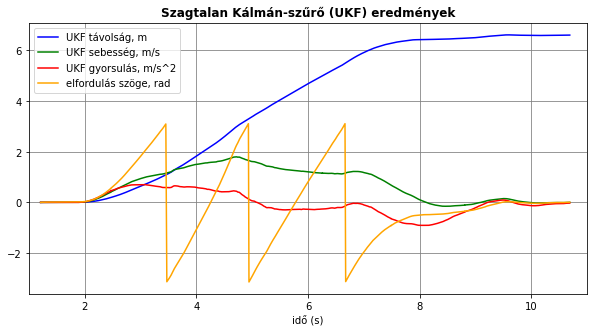

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UKF import MerweScaledSigmaPoints as SP
from UKF import UnscentedKalmanFilter as UKF 


# szagtalan Kálmán-szűrő (SzKSz) (unscented Kalman filter)

def f(x,dt):
    """ állapot terjedés függvénye
     x  = állapot vektor (p,pdot,pdotdot)
     dt = időkülönbség
    """
    f1 = x[0] + x[1]*dt + 0.5*x[2]*dt**2
    f2 = x[1] + x[2]*dt
    f3 = x[2]
    return np.array([f1,f2,f3]).flatten()


def h(x,rs=0.095,rw=0.35):
    ## mérési egyenlet függvénye
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()

"""
Szagtalan Kálmán-szűrő (UKF) kéttengelyű gyorsulásmérő szenzoros odometriához
 t - mérési időpontok vektora
 a1, a2 - mért szenzor centripetális és centrifugális gyorsulások (m/s**2)
 q - folyamat zaj variancia (m/s**2)
 r - mérési zaj variancia (m/s**2)
"""

# kerékre szerelt Samsung Galaxy S2 gyorsulásmérő szenzor adatok
data = np.loadtxt("dat/a.txt")
t = data[:,0]
a1= data[:,1]
a2= data[:,2]

# eredményeket tároló változó
nt = t.shape[0]
# nt = 790

# idő, állapot vektor, szögelfordulás: t, p,vel,acc,theta
xe = np.zeros((nt,5))

# szigma-pontok számítása
spts = SP(n=3,alpha=0.1,beta=2.0,kappa=0)
#print spts.weights()

# UKF szűrő létrehozása
ukf = UKF(dim_x=3, dim_z=2, fx=f, hx=h, dt=0.012, points=spts)

q  = 0.07   # folyamat zaj
r  = 5.0    # mérési zaj

Wk = np.array([0, 0, 1])
ukf.P = np.diag([0.01, 0.01, 0.01])
ukf.R = r**2*np.eye(2)
ukf.Q = q**2*np.outer(Wk,Wk)

xe[:,0]=t  # időpontok
rw=0.35    # a kerék sugara

for i in range(1,nt):
    dt = t[i]-t[i-1]
    ukf.predict(dt)
    z = np.array([a1[i],a2[i]])
    ukf.update(z)
    xe[i,1:4] = ukf.x
    om = xe[i,1]/rw  # kerék elfordulási szöge
    xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # szög: (-pi, pi)


## eredmények felrajzolása
plt.figure(figsize=(10,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label='UKF távolság, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='UKF sebesség, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='UKF gyorsulás, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='elfordulás szöge, rad')
plt.xlim(1,11)
plt.grid(color='grey')


plt.title('Szagtalan Kálmán-szűrő (UKF) eredmények', fontweight='bold')
plt.xlabel('idő (s)')
#plt.ylabel(u'távolság (m), gyorsulás (m/s^2)')
#plt.ylabel(u'sebesség (m/s), szög (rad)')
 
plt.legend(loc='upper left', shadow=False)
plt.show()

### Odometria Vinkó Ákos adataival

A kibővített Kálmán-szűréshez hasonlóan a szabadonfutó bicikli kerékre szerelt gyorsulásmérő adataival is elvégezzük a szagtalan Kálmán-szűrést. Az adatokért köszönetet mondunk [Vinkó Ákosnak](https://epito.bme.hu/vinko-akos) (Út és Vasútépítési Tanszék).

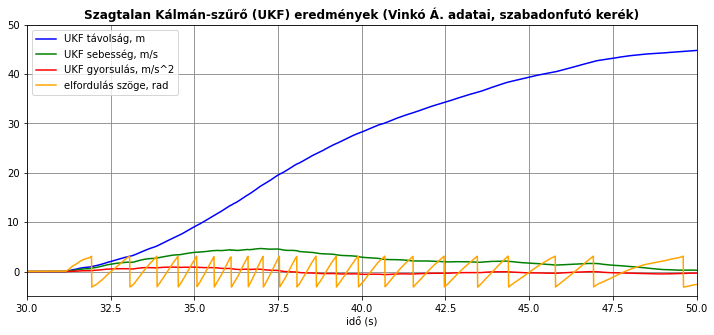

In [2]:
def h(x,rs=0.165,rw=0.33):
    ## mérési egyenlet függvénye
    ## x  = állapot vektor (p,pdot,pdotdot)
    ## rs = szenzor tengelytől mért távolsága
    ## rw = kerék sugara
    g = 9.81
    h1 = -g*np.sin(x[0]/rw) + x[2]*np.cos(x[0]/rw) - x[2]*rs/rw
    h2 = -g*np.cos(x[0]/rw) - x[2]*np.sin(x[0]/rw) - (x[1])**2*rs/(rw**2)
    return np.array([h1,h2]).flatten()


# szabadonfutó kerékre szerelt GCDC gyorsulásmérő szenzor adatok (Vinkó Ákostól)
data = np.loadtxt("dat/asz.dat")
# csak a 30 s utáni szakasz az érdekes számunkra
skip = 96
t = data[skip:,0]
a1= data[skip:,1]
a2= -data[skip:,2]

# eredményeket tároló változó
nt = t.shape[0]

rw=0.33    # a kerék sugara

# idő, állapot vektor, szögelfordulás: t, p,vel,acc,theta
xe = np.zeros((nt,5))
# föntről indul a szenzor, pi szöggel
#dist = np.pi*rw
#xe[0,1] = dist
#xe[0,4] = np.pi

# szigma-pontok számítása
spts = SP(n=3,alpha=0.1,beta=2.0,kappa=0)
#print spts.weights()

# UKF szűrő létrehozása
ukf = UKF(dim_x=3, dim_z=2, fx=f, hx=h, dt=0.012, points=spts)

q  = 0.01   # folyamat zaj
r  = 10.0    # mérési zaj

Wk = np.array([0, 0, 1])
ukf.P = np.diag([0.01, 0.01, 0.01])
ukf.R = r**2*np.eye(2)
ukf.Q = q**2*np.outer(Wk,Wk)

xe[:,0]=t  # időpontok


for i in range(1,nt):
    dt = t[i]-t[i-1]
    ukf.predict(dt)
    z = np.array([a1[i],a2[i]])
    ukf.update(z)
    xe[i,1:4] = ukf.x
    om = xe[i,1]/rw  # kerék elfordulási szöge
    xe[i,4]=np.arctan2(np.sin(om),np.cos(om));  # szög: (-pi, pi)


## eredmények felrajzolása
plt.figure(figsize=(12,5))
plt.plot(xe[:,0],xe[:,1], 'b-', label='UKF távolság, m')
plt.plot(xe[:,0],xe[:,2], 'g-', label='UKF sebesség, m/s')
plt.plot(xe[:,0],xe[:,3], 'r-', label='UKF gyorsulás, m/s^2')
plt.plot(xe[:,0],xe[:,4], color='orange', label='elfordulás szöge, rad')
plt.xlim(30,50)
plt.ylim(-5,50)
plt.grid(color='grey')

plt.title('Szagtalan Kálmán-szűrő (UKF) eredmények (Vinkó Á. adatai, szabadonfutó kerék)', fontweight='bold')
plt.xlabel('idő (s)')
#plt.ylabel(u'távolság (m), gyorsulás (m/s^2)')
#plt.ylabel(u'sebesség (m/s), szög (rad)')
 
plt.legend(loc='upper left', shadow=False) 
plt.show()


Nyilván érdemes lenne összehasonlítani a kétféle (UKF, EKF) szűréssel kapott eredményeket, ezt azonban a kedves Olvasóra bízzuk.